<a href="https://colab.research.google.com/github/Manuuflorez/BigData/blob/main/Taller_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [253]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score

In [254]:
# Leer el archivo Excel.
dataset = pd.read_excel("BBDD_Hospitalización.xlsx")

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [255]:
# Eliminar las variables no relevantes.
# La variable CUP no contribuye directamente al objetivo de estudio, no es relevante para el análisis.
# Las variables DIAS HOSPITALIZACION MQ y DIAS HOSPITALIZACIÓN UPC son menos relevantes para la predicción de la hospitalización.
# Las variables TIPO DE CULTIVO y PATRON DE RESISTENCIA están más relacionadas con el tratamiento de la infección que con la predicción de la hospitalización.
dataset = dataset.drop(['CUP', 'TIPO DE CULTIVO', 'PATRON DE RESISTENCIA',
                        'DIAS HOSPITALIZACION MQ', 'DIAS HOSPITALIZACIÓN UPC'], axis=1)

In [256]:
dataset.head()

,EDAD,DIABETES,HOSPITALIZACIÓN ULTIMO MES,PSA,BIOPSIAS PREVIAS,VOLUMEN PROSTATICO,ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS,NUMERO DE MUESTRAS TOMADAS,ENF. CRONICA PULMONAR OBSTRUCTIVA,BIOPSIA,NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA,FIEBRE,ITU,AGENTE AISLADO,HOSPITALIZACION
0,53.0,NO,NO,4.0,NO,SI,FLUOROQUINOLONA_AMINOGLICOSIDO,12.0,NO,NEG,1,SI,NO,NO,SI
1,56.0,NO,NO,7.7,NO,SI,FLUOROQUINOLONA_AMINOGLICOSIDO,12.0,NO,NEG,1,SI,NO,NO,SI
2,57.0,NO,NO,29.0,SI,SI,FLUOROQUINOLONA_AMINOGLICOSIDO,24.0,NO,NEG,1,SI,NO,E.COLI,SI
3,56.0,NO,NO,7.0,NO,SI,FLUOROQUINOLONA_AMINOGLICOSIDO,12.0,NO,NEG,1,SI,NO,NO,SI
4,55.0,NO,NO,29.0,SI,SI,FLUOROQUINOLONA_AMINOGLICOSIDO,24.0,NO,NEG,1,SI,NO,E.COLI,SI


In [257]:
# Mostrar la cantidad de nulos.
print(dataset.isnull().sum())

EDAD                                                                          2
DIABETES                                                                      2
HOSPITALIZACIÓN ULTIMO MES                                                    2
PSA                                                                           6
BIOPSIAS PREVIAS                                                              4
VOLUMEN PROSTATICO                                                            3
ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS                                       2
NUMERO DE MUESTRAS TOMADAS                                                    2
ENF. CRONICA PULMONAR OBSTRUCTIVA                                             4
BIOPSIA                                                                       2
NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA     2
FIEBRE                                                                        2
ITU                                     

In [258]:
# Eliminar filas con valores nulos en la variable HOSPITALIZACION ya que es la variable objetivo.
dataset = dataset.dropna(subset=['HOSPITALIZACION'])
print(dataset.isnull().sum())

EDAD                                                                          0
DIABETES                                                                      0
HOSPITALIZACIÓN ULTIMO MES                                                    0
PSA                                                                           4
BIOPSIAS PREVIAS                                                              2
VOLUMEN PROSTATICO                                                            1
ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS                                       0
NUMERO DE MUESTRAS TOMADAS                                                    0
ENF. CRONICA PULMONAR OBSTRUCTIVA                                             2
BIOPSIA                                                                       0
NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA     0
FIEBRE                                                                        0
ITU                                     

In [259]:
# Reemplazaremos los valores nulos con la mediana de cada columna, ya que es una medida robusta y menos sensible a valores atípicos.
# Imputación de valores para columnas numéricas, se saca la mediana de cada dato y se reemplazan los nulos.
median_edad = dataset['EDAD'].median()
median_psa = dataset['PSA'].median()

dataset['EDAD'].fillna(median_edad, inplace=True)
dataset['PSA'].fillna(median_psa, inplace=True)

<ipython-input-259-1d666dbcba08>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['EDAD'].fillna(median_edad, inplace=True)
<ipython-input-259-1d666dbcba08>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['PSA'].fillna(median_psa, inplace=True)


In [260]:
# Reemplazaremos los valores nulos con el valor más frecuente de cada columna, ya que es una manera adecuada de mantener la
# distribución de los datos.
# Imputación de valores para columnas categóricas, se busca el valor mas frecuente de cada dato y se reemplazan los nulos.
mode_enf = dataset['ENF. CRONICA PULMONAR OBSTRUCTIVA'].mode()[0]
mode_volumen_prostatico = dataset['VOLUMEN PROSTATICO'].mode()[0]
mode_biopsias = dataset['BIOPSIAS PREVIAS'].mode()[0]
mode_agente = dataset['AGENTE AISLADO'].mode()[0]

dataset['ENF. CRONICA PULMONAR OBSTRUCTIVA'].fillna(mode_enf, inplace=True)
dataset['AGENTE AISLADO'].fillna(mode_agente, inplace=True)
dataset['BIOPSIAS PREVIAS'].fillna(mode_biopsias, inplace=True)
dataset['VOLUMEN PROSTATICO'].fillna(mode_volumen_prostatico, inplace=True)

<ipython-input-260-9818d8ebedd5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['ENF. CRONICA PULMONAR OBSTRUCTIVA'].fillna(mode_enf, inplace=True)
<ipython-input-260-9818d8ebedd5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['AGENTE AISLADO'].fillna(mode_agente, inplace=True)
<ipython-input-260-9818d8ebedd5>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['BIOPSIAS PREVIAS'].fillna(mode_biopsias, inpla

In [261]:
# Verificación de nulos
print(dataset.isnull().sum())

EDAD                                                                         0
DIABETES                                                                     0
HOSPITALIZACIÓN ULTIMO MES                                                   0
PSA                                                                          0
BIOPSIAS PREVIAS                                                             0
VOLUMEN PROSTATICO                                                           0
ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS                                      0
NUMERO DE MUESTRAS TOMADAS                                                   0
ENF. CRONICA PULMONAR OBSTRUCTIVA                                            0
BIOPSIA                                                                      0
NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA    0
FIEBRE                                                                       0
ITU                                                 

In [262]:
dataset.head()

,EDAD,DIABETES,HOSPITALIZACIÓN ULTIMO MES,PSA,BIOPSIAS PREVIAS,VOLUMEN PROSTATICO,ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS,NUMERO DE MUESTRAS TOMADAS,ENF. CRONICA PULMONAR OBSTRUCTIVA,BIOPSIA,NUMERO DE DIAS POST BIOPSIA EN QUE SE PRESENTA LA COMPLICACIÓN INFECCIOSA,FIEBRE,ITU,AGENTE AISLADO,HOSPITALIZACION
0,53.0,NO,NO,4.0,NO,SI,FLUOROQUINOLONA_AMINOGLICOSIDO,12.0,NO,NEG,1,SI,NO,NO,SI
1,56.0,NO,NO,7.7,NO,SI,FLUOROQUINOLONA_AMINOGLICOSIDO,12.0,NO,NEG,1,SI,NO,NO,SI
2,57.0,NO,NO,29.0,SI,SI,FLUOROQUINOLONA_AMINOGLICOSIDO,24.0,NO,NEG,1,SI,NO,E.COLI,SI
3,56.0,NO,NO,7.0,NO,SI,FLUOROQUINOLONA_AMINOGLICOSIDO,12.0,NO,NEG,1,SI,NO,NO,SI
4,55.0,NO,NO,29.0,SI,SI,FLUOROQUINOLONA_AMINOGLICOSIDO,24.0,NO,NEG,1,SI,NO,E.COLI,SI


In [263]:
# Mapeo
mapeo_diabetes = {'NO': 0, 'SI': 1}
mapeo_hospitalizacionMes = {'NO': 0, 'SI': 1}
mapeo_biopsiaPrev = {'NO': 0, 'SI': 1}
mapeo_volProst = {'NO': 0, 'SI': 1}
mapeo_fiebre = {'NO': 0, 'SI': 1}
mapeo_itu = {'NO': 0, 'SI': 1}
mapeo_hospitalizacion = {'NO': 0, 'SI': 1}
# Actualizacion de las variables utilizando el mapeo
dataset['DIABETES'] = dataset['DIABETES'].map(mapeo_diabetes)
dataset['HOSPITALIZACIÓN ULTIMO MES'] = dataset['HOSPITALIZACIÓN ULTIMO MES'].map(mapeo_hospitalizacionMes)
dataset['BIOPSIAS PREVIAS'] = dataset['BIOPSIAS PREVIAS'].map(mapeo_biopsiaPrev)
dataset['VOLUMEN PROSTATICO'] = dataset['VOLUMEN PROSTATICO'].map(mapeo_volProst)
dataset['FIEBRE'] = dataset['FIEBRE'].map(mapeo_fiebre)
dataset['ITU'] = dataset['ITU'].map(mapeo_itu)
dataset['HOSPITALIZACION'] = dataset['HOSPITALIZACION'].map(mapeo_hospitalizacion)

In [264]:
# Codificar variables categóricas como variables binarias utilizando la técnica one-hot encoding
dataset = pd.get_dummies(dataset, columns=['ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS', 'ENF. CRONICA PULMONAR OBSTRUCTIVA',
                                           'BIOPSIA', 'AGENTE AISLADO'])


In [265]:
# Lista de columnas seleccionadas como características para el modelo
feature_cols = ['EDAD', 'DIABETES', 'HOSPITALIZACIÓN ULTIMO MES', 'PSA', 'BIOPSIAS PREVIAS', 'VOLUMEN PROSTATICO',
                'NUMERO DE MUESTRAS TOMADAS', 'FIEBRE', 'ITU', 'ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS_CEFALOSPORINA_AMINOGLUCOCIDO',
                'ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS_FLUOROQUINOLONA_AMINOGLICOSIDO',
                'ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS_FLUOROQUINOLONA_AMINOGLICÓSIDO',
                'ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS_OROQUINOLONAS', 'ANTIBIOTICO UTILIAZADO EN LA PROFILAXIS_OTROS',
                'ENF. CRONICA PULMONAR OBSTRUCTIVA_NO', 'ENF. CRONICA PULMONAR OBSTRUCTIVA_SI',
                'ENF. CRONICA PULMONAR OBSTRUCTIVA_SI, ASMA', 'ENF. CRONICA PULMONAR OBSTRUCTIVA_SI, EPOC',
                'BIOPSIA_ADENOCARCINOMA GLEASON 10 ', 'BIOPSIA_ADENOCARCINOMA GLEASON 6', 'BIOPSIA_ADENOCARCINOMA GLEASON 6 ',
                'BIOPSIA_ADENOCARCINOMA GLEASON 7', 'BIOPSIA_ADENOCARCINOMA GLEASON 7 ', 'BIOPSIA_ADENOCARCINOMA GLEASON 8 ',
                'BIOPSIA_ADENOCARCINOMA GLEASON 9 ', 'BIOPSIA_CARCINOMA INDIFERENCIADO DE CELULAS CLARAS', 'BIOPSIA_HIPERPLASIA PROSTATICA',
                'BIOPSIA_NEG', 'BIOPSIA_PROSTATITIS', 'AGENTE AISLADO_E.COLI', 'AGENTE AISLADO_NO', 'AGENTE AISLADO_PSEUDOMONAS AERUGINOSA']

In [266]:
# Separación de los datos en características (X) y variable objetivo (y)
X = dataset[feature_cols]  # Características
y = dataset['HOSPITALIZACION']  # Variable objetivo

# División de los datos en conjunto de entrenamiento y conjunto de prueba
# El 20% de los datos se utilizarán como conjunto de prueba, mientras que el 80% restante se utilizará como conjunto de entrenamiento.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [267]:
# Se crea un clasificador de árbol de decisión con una profundidad máxima de 4
clf = DecisionTreeClassifier(max_depth=4)

# Se entrena el clasificador utilizando los datos de entrenamiento X_train y las etiquetas y_train
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

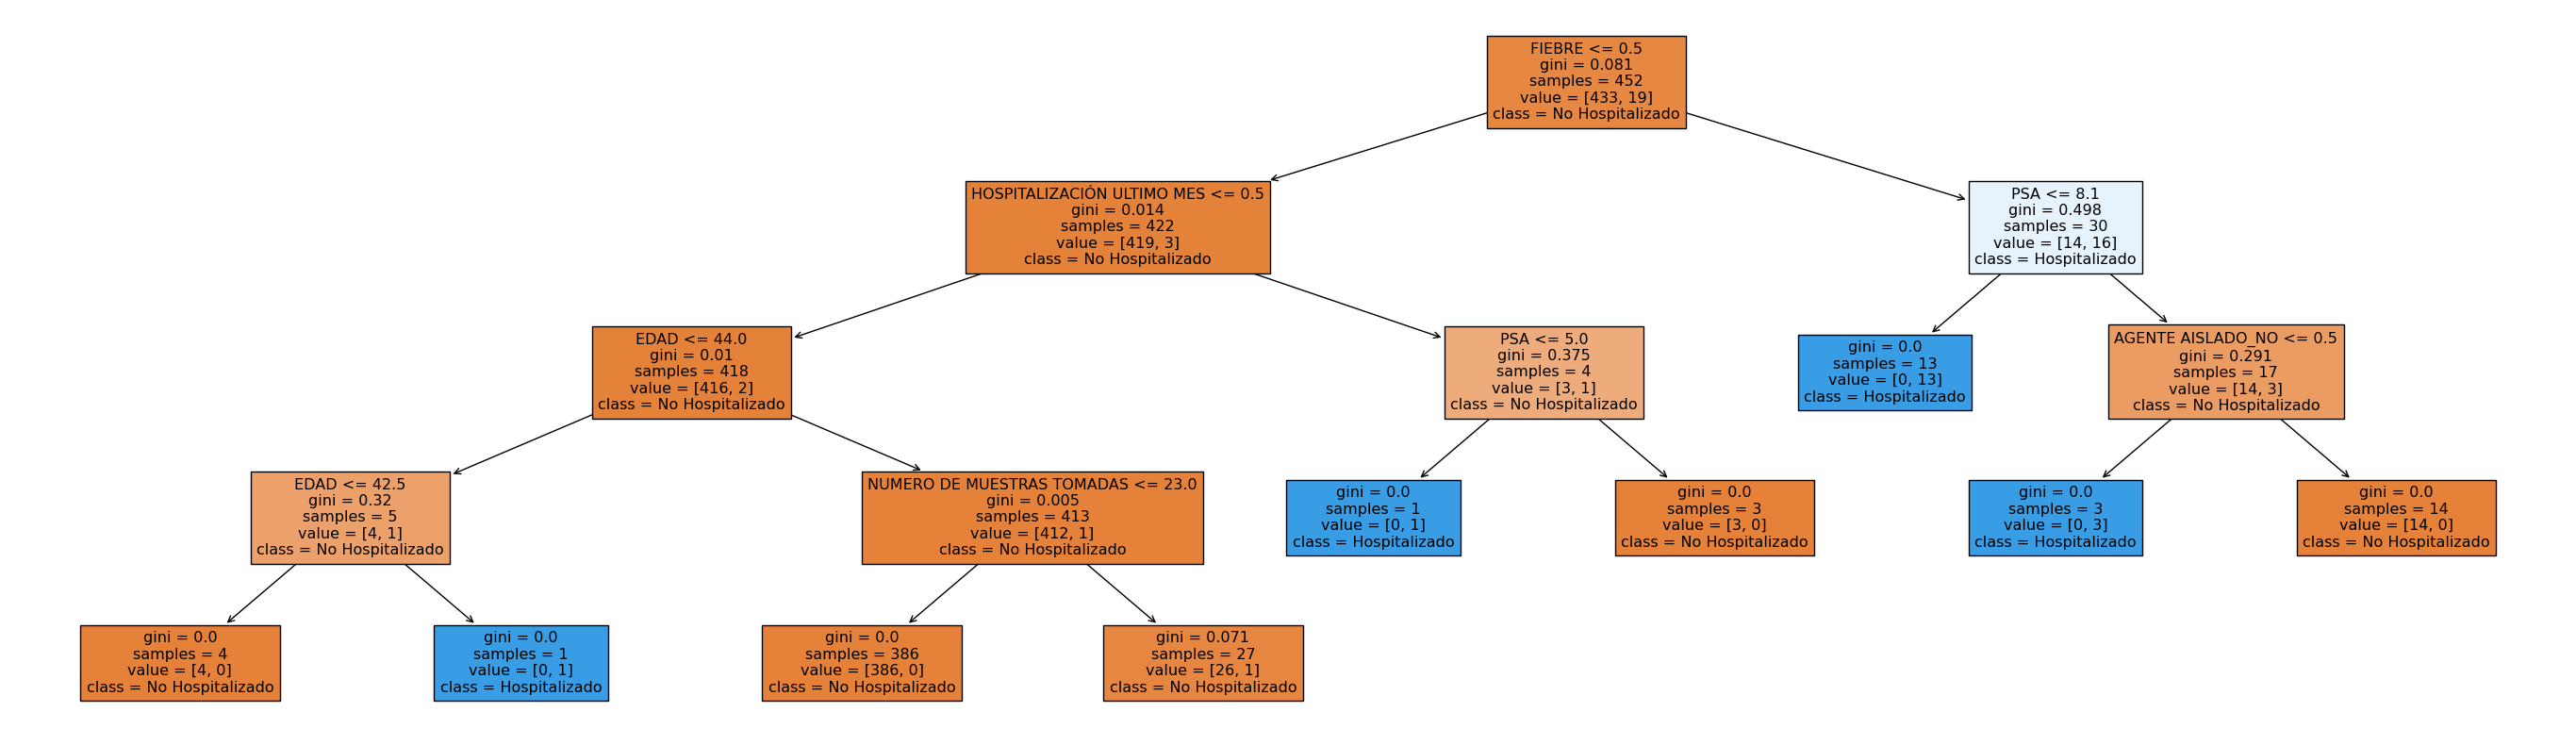

In [268]:
# Se crea una figura con un tamaño específico para mostrar el árbol de decisiones
plt.figure(figsize=(35, 10))

# Se utiliza la función plot_tree para dibujar el árbol de decisiones entrenado
tree.plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=['No Hospitalizado', 'Hospitalizado'])

# Se muestra el árbol de decisiones
plt.show()


In [269]:
# Realizar predicciones en los datos de prueba
y_pred = clf.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0])

In [270]:
# Matriz de confusion
cm = confusion_matrix(y_test, y_pred)
cm

# Verdaderos negativos (TN): 108
# Falsos positivos (FP): 0
# Falsos negativos (FN): 0
# Verdaderos positivos (TP): 5
# El modelo hizo 108 predicciones correctas de pacientes que no requirieron hospitalización,
# y 5 predicciones correctas de pacientes que sí requirieron hospitalización.

array([[108,   0],
       [  0,   5]])

In [271]:
# Puntaje de precisión
precision_score(y_test, y_pred)

# Todas las predicciones positivas fueron correctas, no hubo falsos positivos en las predicciones.

1.0

In [272]:
# Calcular la precisión del clasificador
accuracy = accuracy_score(y_test, y_pred)
# Mostrar la precisión del clasificador
print("Precisión del clasificador de árbol de decisión:", accuracy)

Precisión del clasificador de árbol de decisión: 1.0
